In [2]:
!python train_agent.py --outdir=./ver2/ --channel=2 --weight=0.05 --end=1

^C
Traceback (most recent call last):
  File "train_agent.py", line 266, in <module>
    train(channel=args.channel, weight=args.weight, outdir=args.outdir, gpu=args.gpu, seed=seed)
  File "train_agent.py", line 196, in train
    s, r, history = step(Qnet, s, history, filt, channel, gamma=gamma, eps=eps, device=device)
  File "train_agent.py", line 94, in step
    r_next = reward(s, s_next, a)
  File "train_agent.py", line 76, in reward
    return - torch.mean((x_next[0, 0] - y[0, 0])**2).item()
KeyboardInterrupt


In [2]:
import pickle

from scipy.stats import multivariate_normal
from scipy.signal import fftconvolve
from skimage import restoration
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
from torchvision import datasets

from tqdm.notebook import tqdm
from train_agent import MnistNet, blur, augument_data, get_gauss_filt

In [2]:
def moving_average(r, n=100, label=''):
    ret = np.cumsum(r)
    ret[n:] = ret[n:] - ret[:-n]
    moving_average = ret[n - 1:] / n
    return moving_average


def show_rewards(dir_path, n=1000, label='', head=None):
    plt.xlabel('Training Episodes')
    plt.ylabel('Average Reward')
    plt.ylim(-0.25, -0.1)
    with open('%s/reward.pkl' % dir_path, 'rb') as f2:
        reward = pickle.load(f2)
    ma = moving_average(reward, n=n, label=label)
    plt.plot(ma, label=label)
#     plt.legend(bbox_to_anchor=(-0.5, 0), loc='lower left')

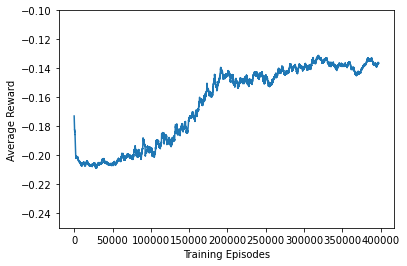

In [3]:
# check (c, lambda) = (1, 0.0)
show_rewards('channel01_weight000_seed00', n=3000)

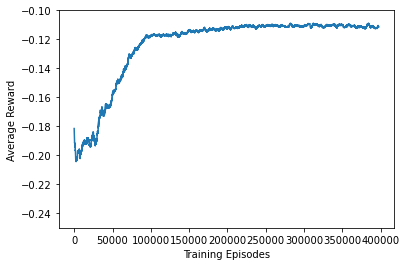

In [275]:
# check (c, lambda) = (1, 0.05)
show_rewards('channel01_weight005_seed00/', n=3000)

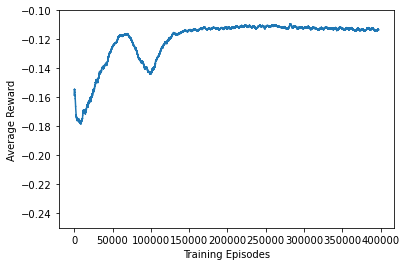

In [311]:
# check (c, lambda) = (1, 0.05)
show_rewards('channel02_weight000_seed00/', n=3000)

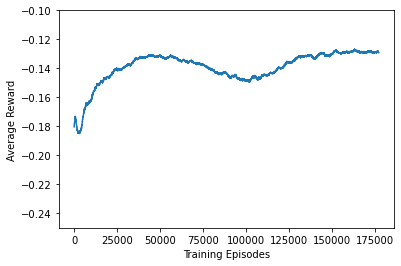

In [18]:
# check (c, lambda) = (1, 0.05)
show_rewards('ver2/channel02_weight005_seed00/', n=3000)

↓結果の確認

In [3]:
SEED = 0
DEVICE = 'cuda:0'    
C = 1
N = 1000
T = 5
COMPARE_TRIAL_NUM = 1000
SIZE = 5

In [4]:
kernel1 = get_gauss_filt(np.diag([2.0**2]*2), size=SIZE)
kernel2 = get_gauss_filt(np.diag([10**2, 10**2]), size=SIZE)
kernel3 = get_gauss_filt(np.diag([16**2, 2**2]), size=SIZE)

In [5]:
filt = []
filt.append(lambda x: x)
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel1, 1e-2)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel2, 1e-2)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel3, 1e-2)))

ちゃんと区別できるフィルターになっているかチェックする

In [6]:
### test data
np.random.seed(SEED)
test_data = datasets.MNIST(root='./data', train=False, download=True)
test_data = test_data.data/255.0

In [59]:
gauss2

array([[0.01089665, 0.01089828, 0.01089883, 0.01089828, 0.01089665],
       [0.04883538, 0.04884271, 0.04884515, 0.04884271, 0.04883538],
       [0.08051594, 0.08052802, 0.08053204, 0.08052802, 0.08051594],
       [0.04883538, 0.04884271, 0.04884515, 0.04884271, 0.04883538],
       [0.01089665, 0.01089828, 0.01089883, 0.01089828, 0.01089665]])

In [61]:
gauss2

array([[0.01078893, 0.01095198, 0.01100688, 0.01095198, 0.01078893],
       [0.04835261, 0.04908336, 0.0493294 , 0.04908336, 0.04835261],
       [0.07971997, 0.08092479, 0.08133042, 0.08092479, 0.07971997],
       [0.04835261, 0.04908336, 0.0493294 , 0.04908336, 0.04835261],
       [0.01078893, 0.01095198, 0.01100688, 0.01095198, 0.01078893]])

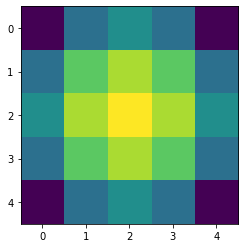

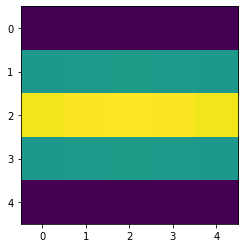

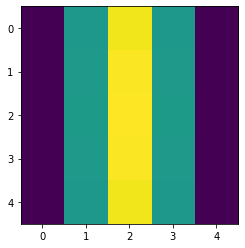

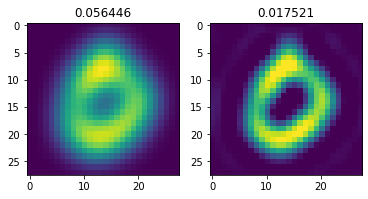

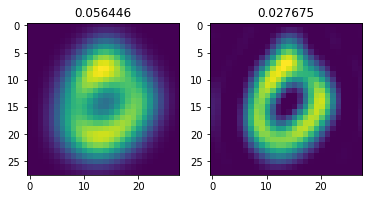

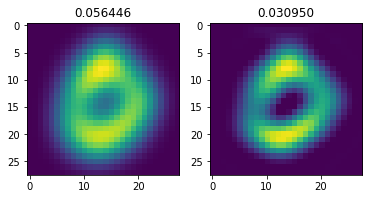

In [67]:
gauss1 = get_gauss_filt(np.diag([10**2, 10**2]), size=SIZE)
gauss2 = get_gauss_filt(np.diag([10**2, 1]), size=SIZE)
gauss3 = get_gauss_filt(np.diag([1, 10**2]), size=SIZE)
new_gausses = [gauss1, gauss2, gauss3]

for kernel in new_gausses:
    plt.imshow(kernel)
    plt.show()

o = test_data[3]

b = blur(o, gauss1, c=3)
for kernel in new_gausses:

    r = b.copy()
    for _ in range(3):
        r = np.maximum(0, restoration.wiener(r, kernel, 0.02))
    plt.subplot(121)
    plt.title('%lf' % np.mean((o.numpy() - b)**2))
    plt.imshow(b)
    
    plt.subplot(122)
    plt.title('%lf' % np.mean((o.numpy()-r)**2))
    plt.imshow(r)
    plt.show()

In [16]:
blurred_imgs = [blur(o, gauss1, c=3) for o in original_imgs]

In [68]:
filt = []
filt.append(lambda x: x)
filt.append(lambda x: np.maximum(0, restoration.wiener(x, gauss1, 0.02)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, gauss2, 0.02)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, gauss3, 0.02)))

In [49]:
b = blurred_imgs[2]

r1 = filt3times(b, filt[1])
r2 = filt3times(b, filt[2])
np.allclose(r1, r2)

False

In [26]:
# At first, prepare blurred_imgs. Since this evaluation is small test, you don't have to use train images, to say you may use test images.

# test evaluation of imgs restored by kernel2 or kernel3 from imgs blurred by kernel1.

original_imgs = test_data
H, W = original_imgs[0].shape
size = H * W

def filt3times(b, f):
    r = b.copy()
    for _ in range(3):
        r = f(r)
    return r

# filt = []
# filt.append(lambda x: x)
# for gauss in new_gausses:
#     filt.append(lambda x: np.maximum(0, restoration.wiener(x, gauss, 1e-2)))

In [69]:
# for kernel in [kernel1, kernel2, kernel3]:
# original_imgs = original_imgs.numpy()
for kernel in new_gausses:
    blurred_imgs = [blur(o, kernel, c=3) for o in original_imgs]
    r = []
    for i in range(1, 4):
        r.append(
            np.array([filt3times(b, filt[i]) for b in blurred_imgs])
        )

    mse1, mse2, mse3 = [], [], []
    for b, r1, r2, r3 in zip(blurred_imgs, *r):
        mse1.append((b-r1)**2)
        mse2.append((b-r2)**2)
        mse3.append((b-r3)**2)
    mse1, mse2, mse3 = np.array(mse1), np.array(mse2), np.array(mse3)
    print(mse1.mean(), mse2.mean(), mse3.mean())

0.01568878901102718 0.007596159998047117 0.006901430913252146
0.04101637703918186 0.013607473663232771 0.034575743502503434
0.042220184970752736 0.035716908966775984 0.013187586793697074


In [3]:
# Qnet10 = MnistNet(c=1, m=[20, 20, len(filt)]).to(DEVICE)
# Qnet10.load_state_dict(torch.load('channel01_weight000_seed00/Qnet020000.pth'))

# Qnet15 = MnistNet(c=1, m=[20, 20, len(filt)]).to(DEVICE)
# Qnet15.load_state_dict(torch.load('channel01_weight005_seed00/Qnet020000.pth'))

# Qnet20 = MnistNet(c=2, m=[20, 20, len(filt)]).to(DEVICE)
# Qnet20.load_state_dict(torch.load('channel02_weight000_seed00/Qnet020000.pth'))

# Qnet25 = MnistNet(c=2, m=[20, 20, len(filt)]).to(DEVICE)
# Qnet25.load_state_dict(torch.load('channel02_weight005_seed00/Qnet020000.pth'))

Qnet25 = MnistNet(c=2, m=[20, 20, len(filt)]).to(DEVICE)
Qnet25.load_state_dict(torch.load('ver2/channel02_weight005_seed00/Qnet009000.pth'))

NameError: name 'filt' is not defined

In [22]:
def restore_by_agent(net, blur_img, t=T, device=DEVICE):
    blur_img = torch.from_numpy(blur_img)
    restore = blur_img.clone()
    actions = []
    for _ in range(t):
        with torch.no_grad():
            feature = restore[None, None, ...] if net.conv1.in_channels == 1 else torch.stack([restore, blur_img], axis=0)[None, ...]
            q, _ = net(feature.to(device, dtype=torch.float))
        _, action_idx = torch.max(q, axis=1)
        actions.append(action_idx.item())
        action = filt[action_idx]
        restore = action(restore.numpy())
        restore = torch.from_numpy(restore)
    return restore, actions


def test_trained_agent(restore_functions, kernel, c=3, trial_num=10000):
    '''
    * to calculate average MSE for restore and initial img
    * to get actions distrubution
    '''
    test_imgs = test_data
    dataset_mse = []
    actions_per_sample = []
    for original_img in test_imgs:
        blur_img = blur(original_img, kernel, c=c)
        case_mse = [torch.mean((original_img-blur_img)**2).item()]
        actions_per_func = []
        for restore_func in restore_functions:
            restore_img, actions = restore_func(blur_img)
            # record mse
            mse = torch.mean((restore_img - original_img)**2).item()
            case_mse.append(mse)
            # record actions
            actions_per_func.append(actions)
        dataset_mse.append(case_mse)
        actions_per_sample.append(actions_per_func)
    return np.array(dataset_mse), np.array(actions_per_sample)

In [61]:
functions = [
#     lambda x: restore_by_agent(Qnet10, x),
#     lambda x: restore_by_agent(Qnet15, x),
#     lambda x: restore_by_agent(Qnet20, x),
    lambda x: restore_by_agent(Qnet25, x),
]
kernels = [
    ('gauss1', kernel1),
    ('gauss2', kernel2),
    ('gauss3', kernel3),
]

mse_result = {}
action_result = {}
for (label, kernel) in tqdm(kernels):
    times_mse = []
    times_action = []
    for times in range(1, 6):
        mse_matrix, actions = test_trained_agent(functions, kernel, times, trial_num=N)
        times_mse.append(mse_matrix)
        times_action.append(actions)
    mse_result[label] = times_mse
    action_result[label] = times_action

In [24]:
QNET_TYPES = ['c01w000', 'c01w005', 'c02w000', 'c02w005']
def show_each_mse(result_matrix):
    for key, res in result_matrix.items():
        for head in [key, 'init'] + QNET_TYPES:
            print(head, end='\t')
        print()
        for c, r in enumerate(res, start=1):
            print(c, '回', end='\t')
            result = r.mean(axis=0)
            for v in result:
                print(f'{v:.4f}', end='\t')
            print()
        print()
        
def view_actions_hist(action_result):
    func_labels = QNET_TYPES
    for filt_label, actions_all_times in action_result.items():
        for i, actions_per_time in enumerate(actions_all_times, start=1):
            print(f'use {i} times {filt_label}')
            actions_all_funcs = actions_per_time.transpose(1, 0, 2)
            for j, actions_per_func in enumerate(actions_all_funcs):
                plt.figure(figsize=(40, 6))
                plt.subplots_adjust(wspace=1)
                for step_num in range(actions_per_func.shape[1]):
                    plt.subplot(1, 5, step_num+1)
                    plt.title(f'{func_labels[j]}/step {step_num+1} of {filt_label}')
                    plt.hist(actions_per_func[:, step_num], bins=range(5))
                    plt.xticks(np.arange(0.5, 4, 1), ['N', 'g1', 'g2', 'g3'])
                plt.show()
        print('-' * 10)
        print()

In [25]:
show_each_mse(mse_result)

gauss1	init	c01w000	c01w005	c02w000	c02w005	
1 回	0.0245	0.0133	
2 回	0.0356	0.0138	
3 回	0.0432	0.0150	
4 回	0.0485	0.0260	
5 回	0.0525	0.0617	

gauss2	init	c01w000	c01w005	c02w000	c02w005	
1 回	0.0300	0.0144	
2 回	0.0395	0.0136	
3 回	0.0471	0.0221	
4 回	0.0521	0.0622	
5 回	0.0559	0.0873	

gauss3	init	c01w000	c01w005	c02w000	c02w005	
1 回	0.0275	0.0143	
2 回	0.0377	0.0143	
3 回	0.0454	0.0173	
4 回	0.0506	0.0394	
5 回	0.0544	0.0764	



use 1 times gauss1


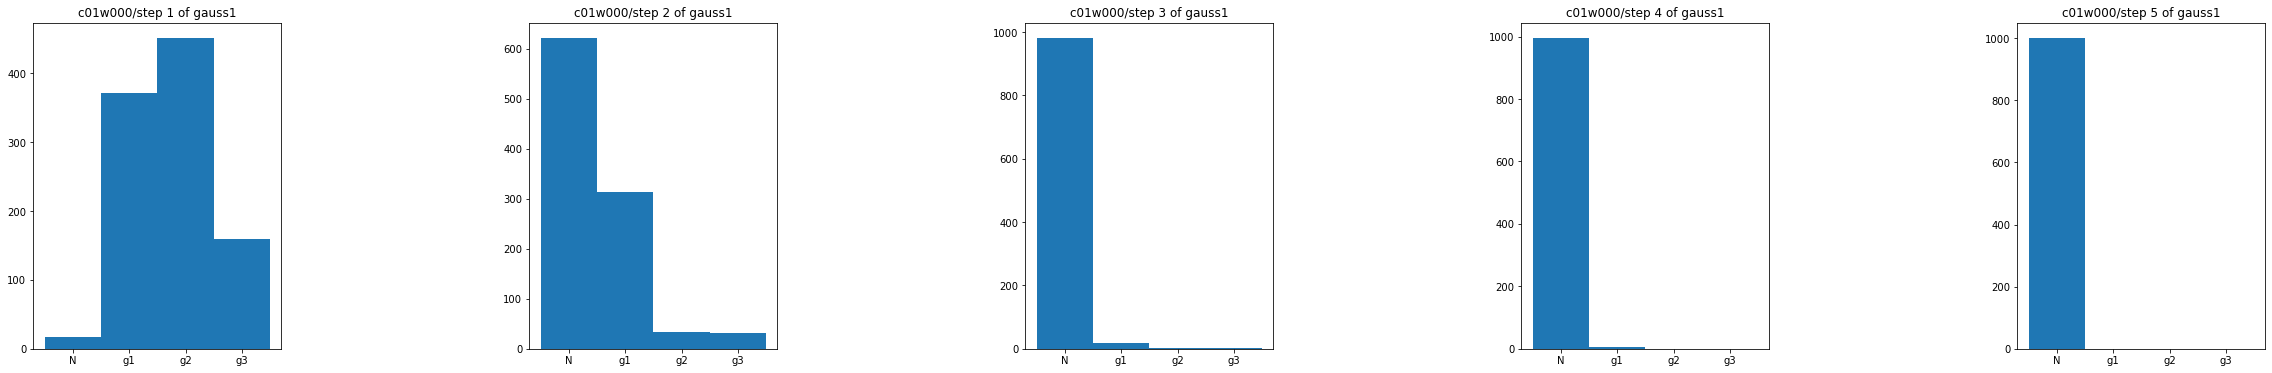

use 2 times gauss1


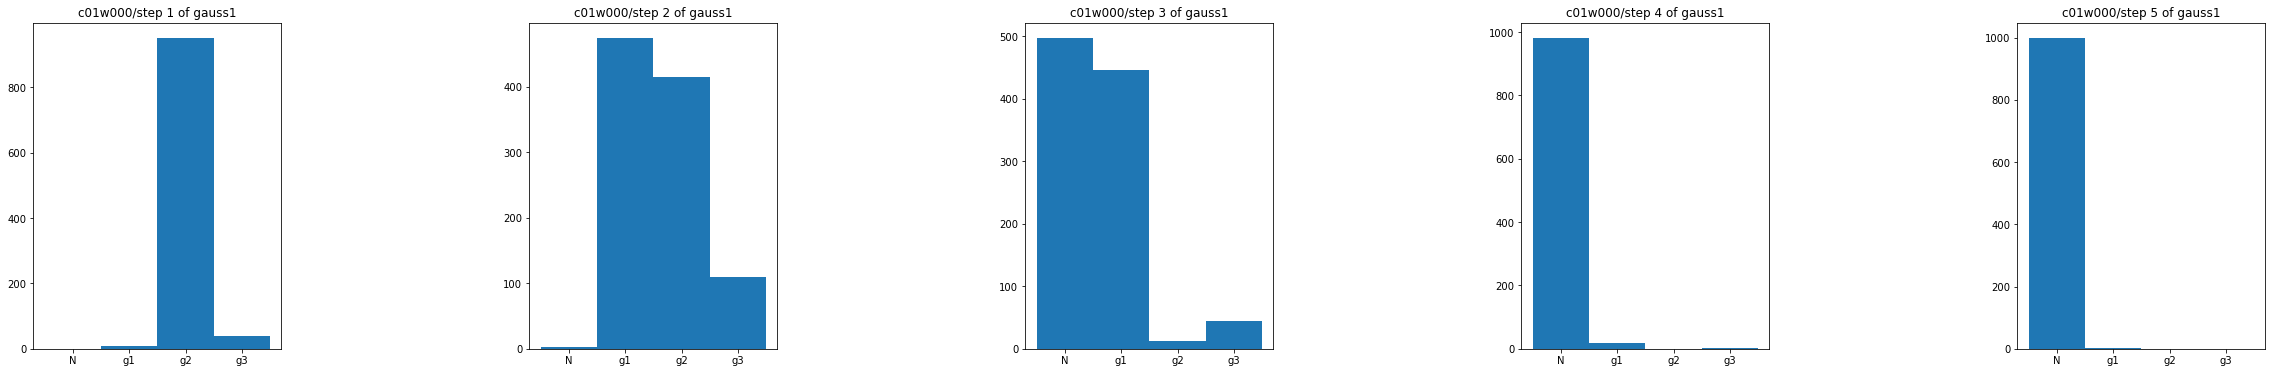

use 3 times gauss1


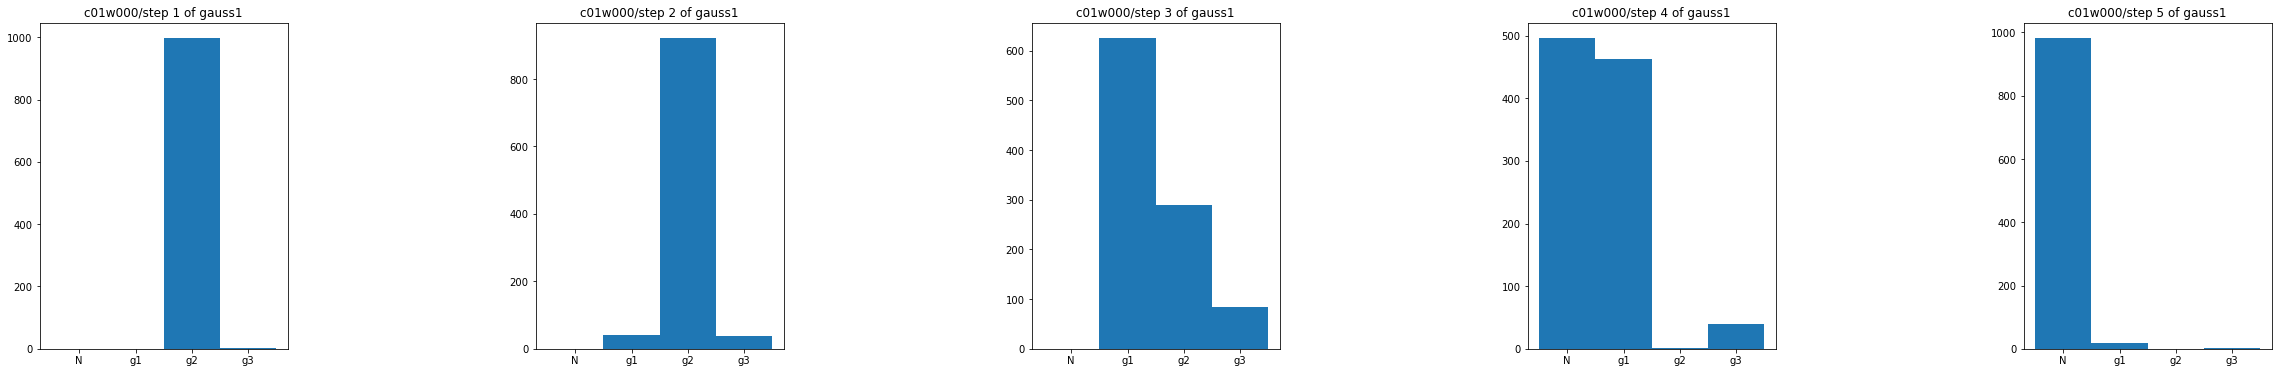

use 4 times gauss1


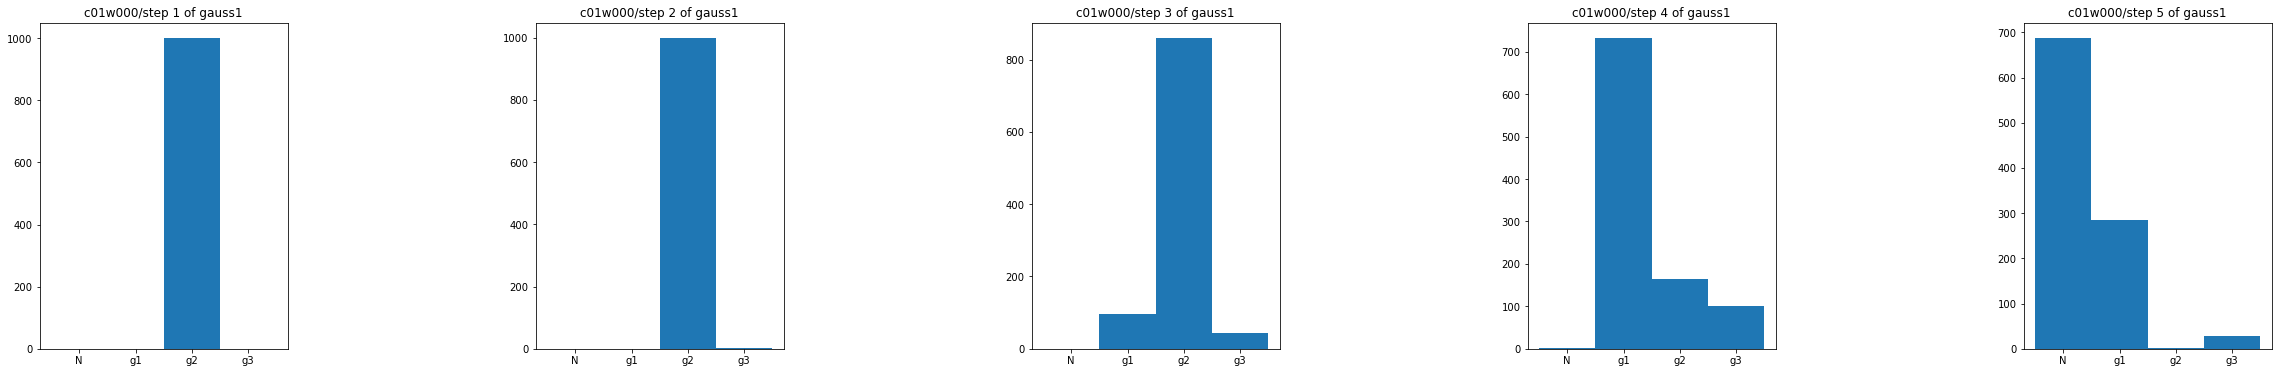

use 5 times gauss1


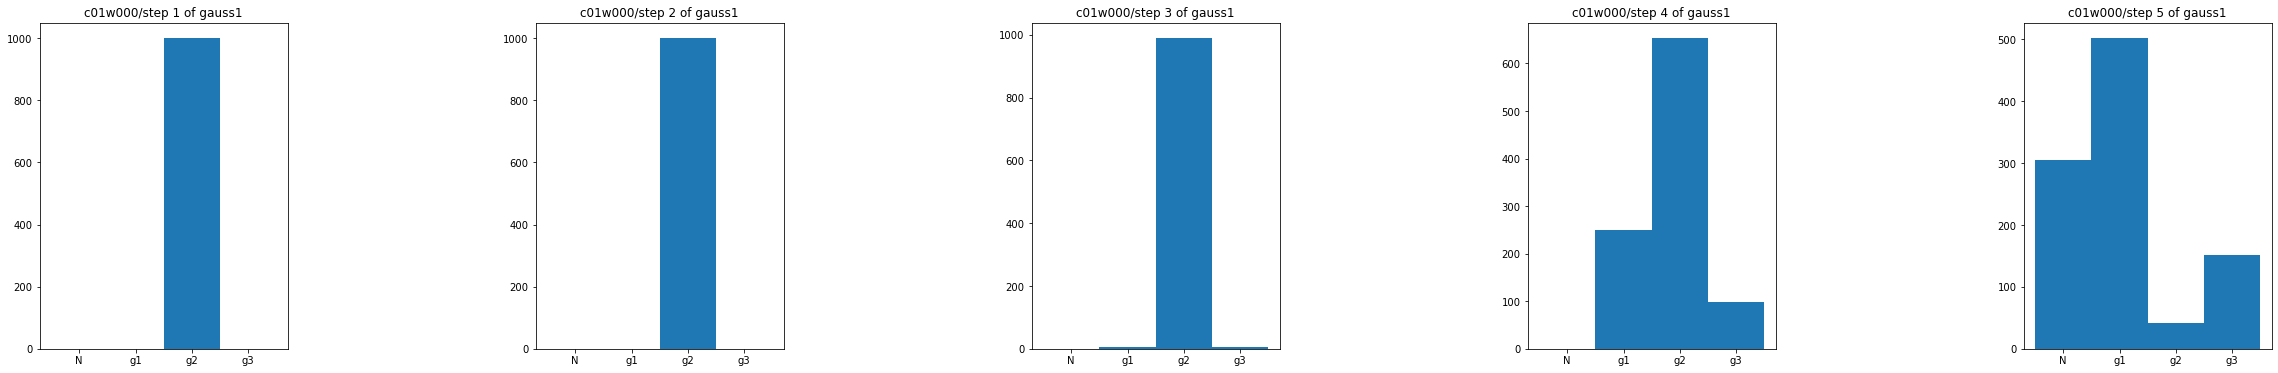

----------

use 1 times gauss2


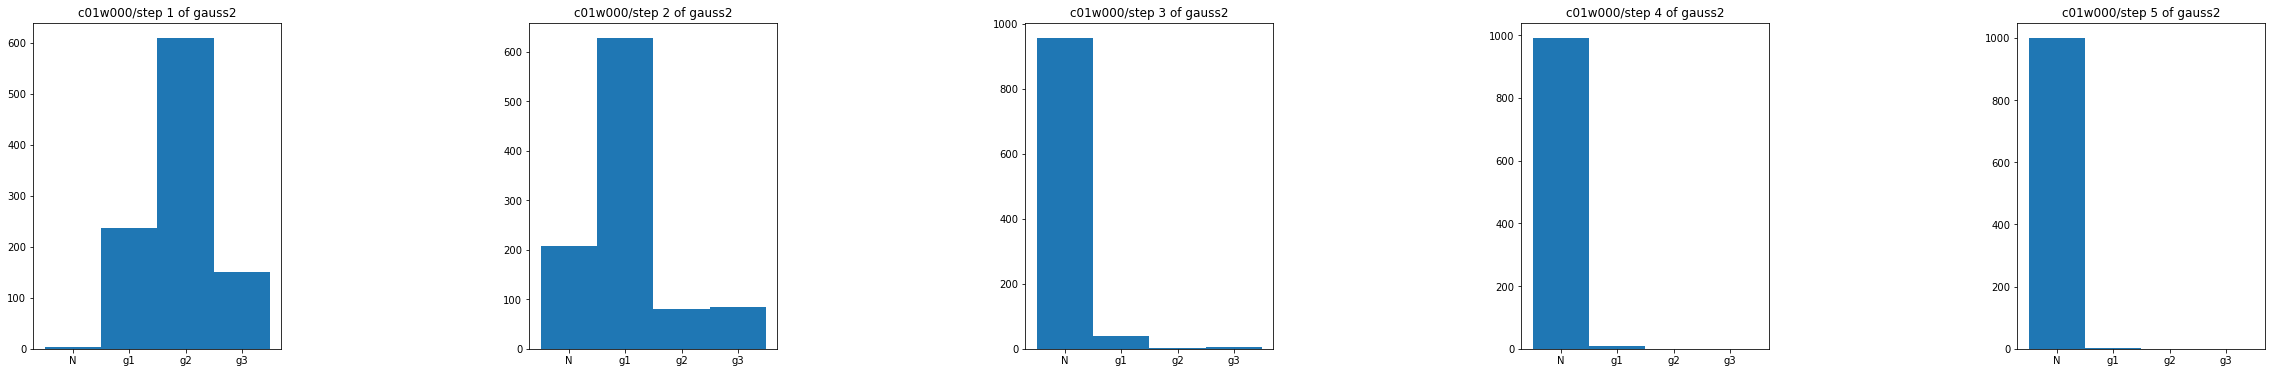

use 2 times gauss2


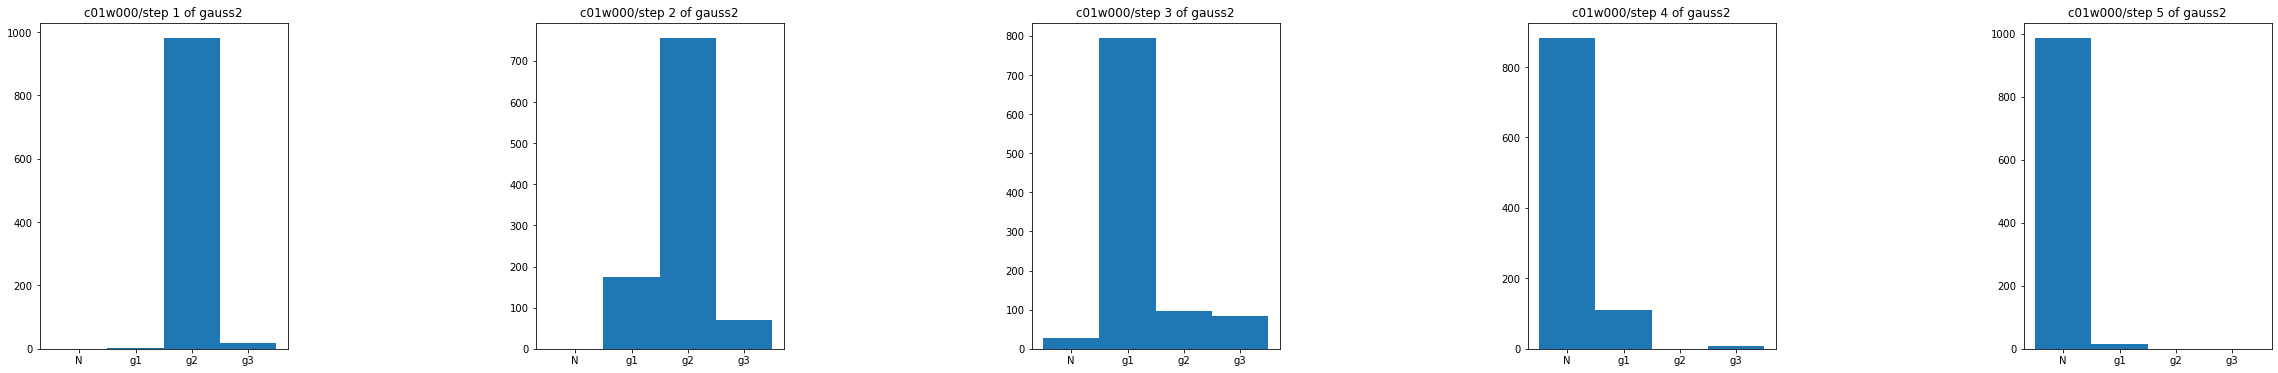

use 3 times gauss2


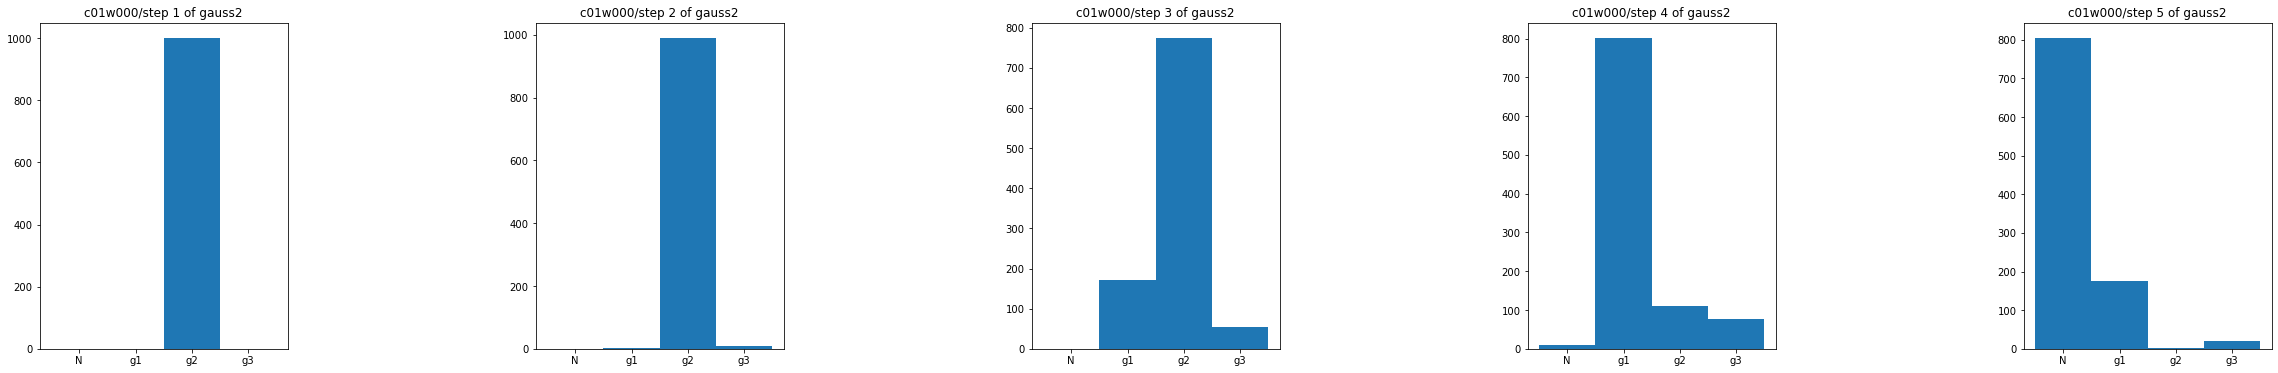

use 4 times gauss2


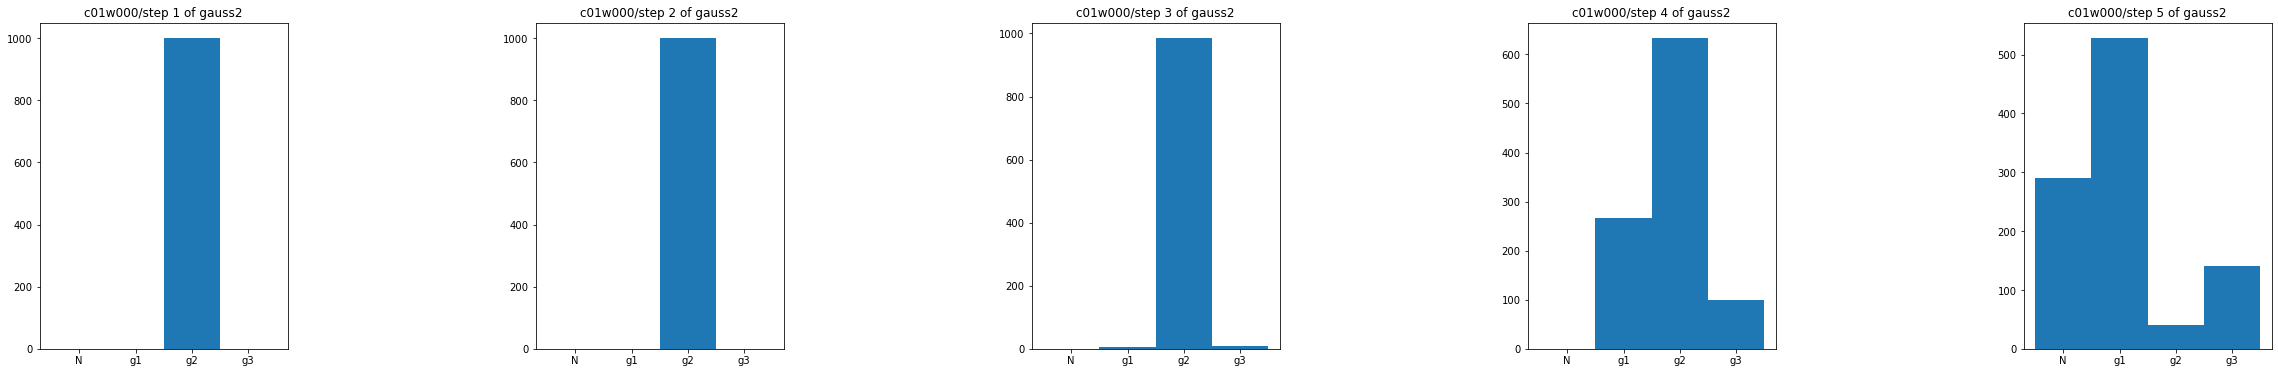

use 5 times gauss2


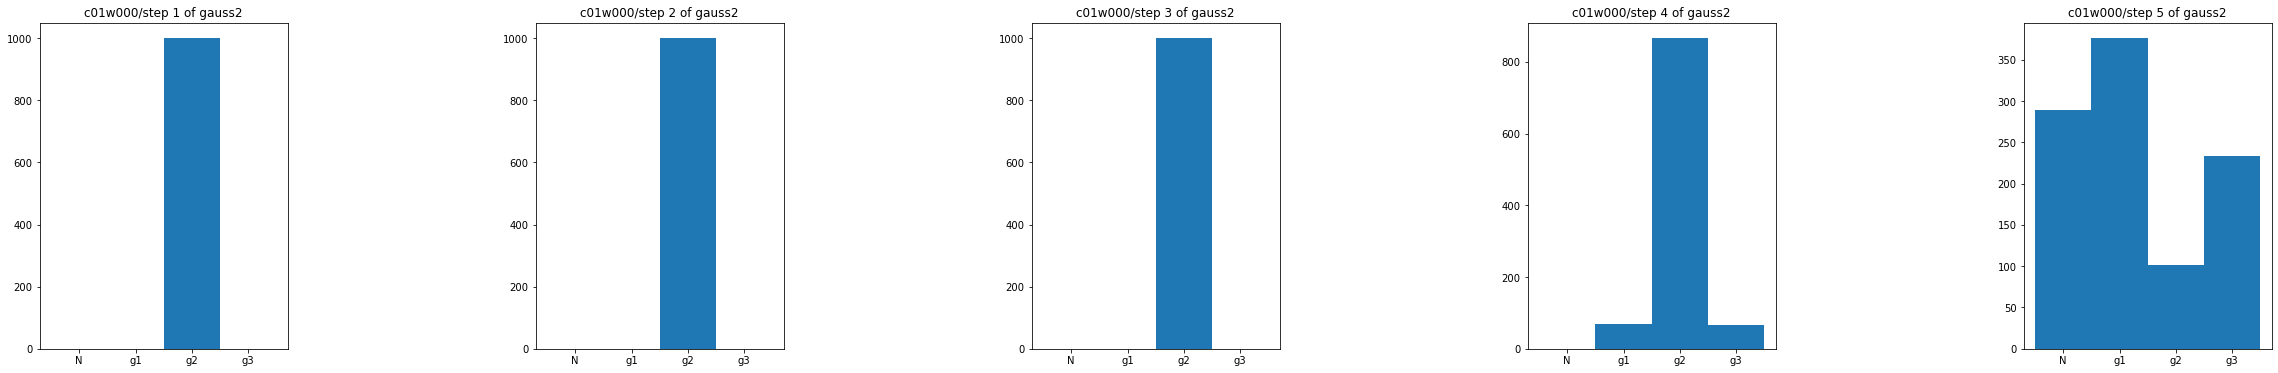

----------

use 1 times gauss3


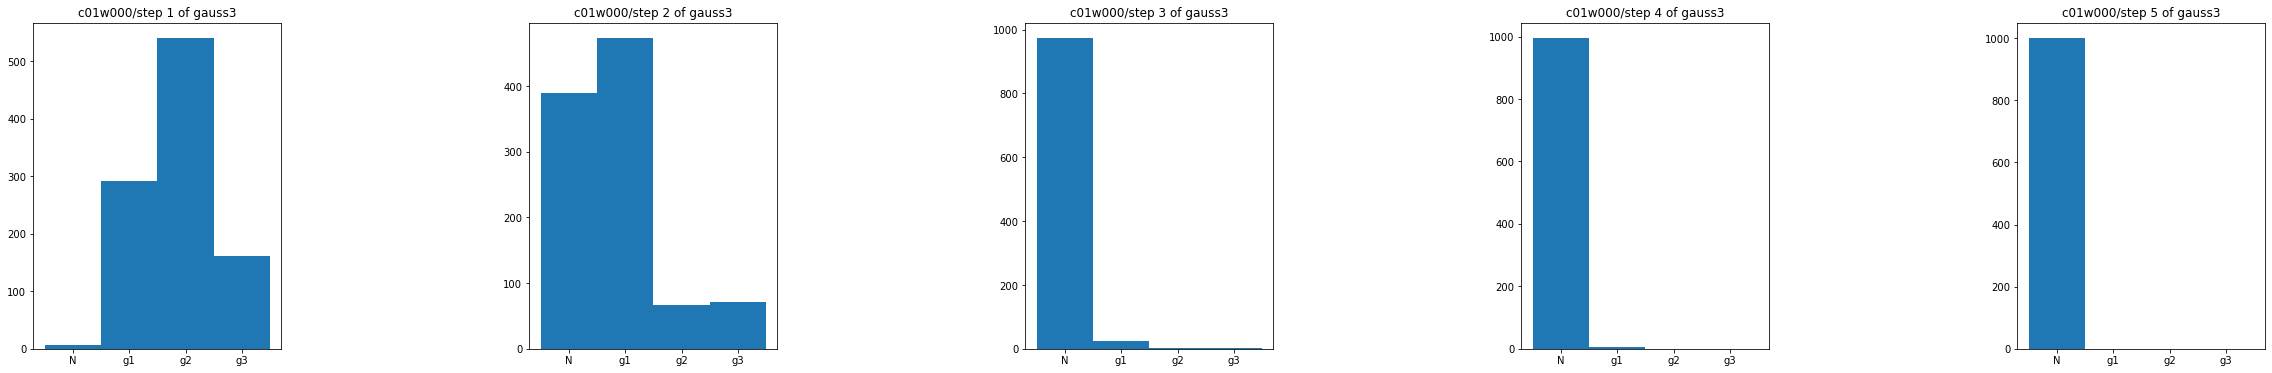

use 2 times gauss3


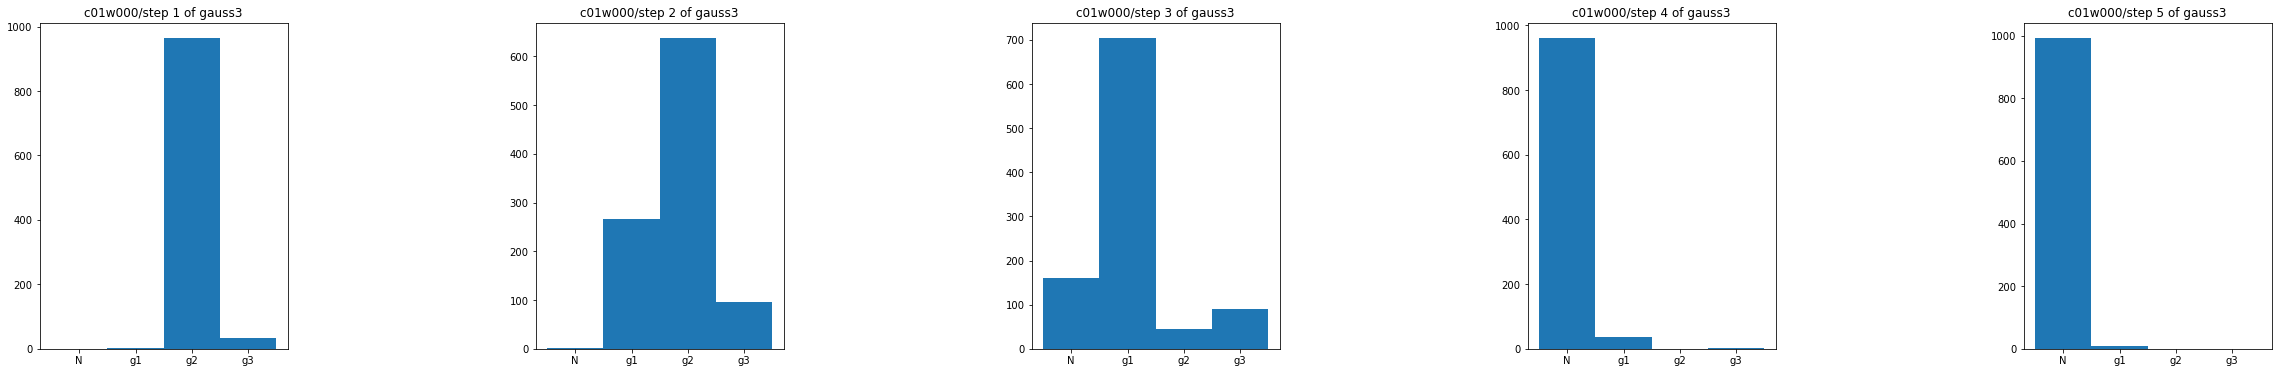

use 3 times gauss3


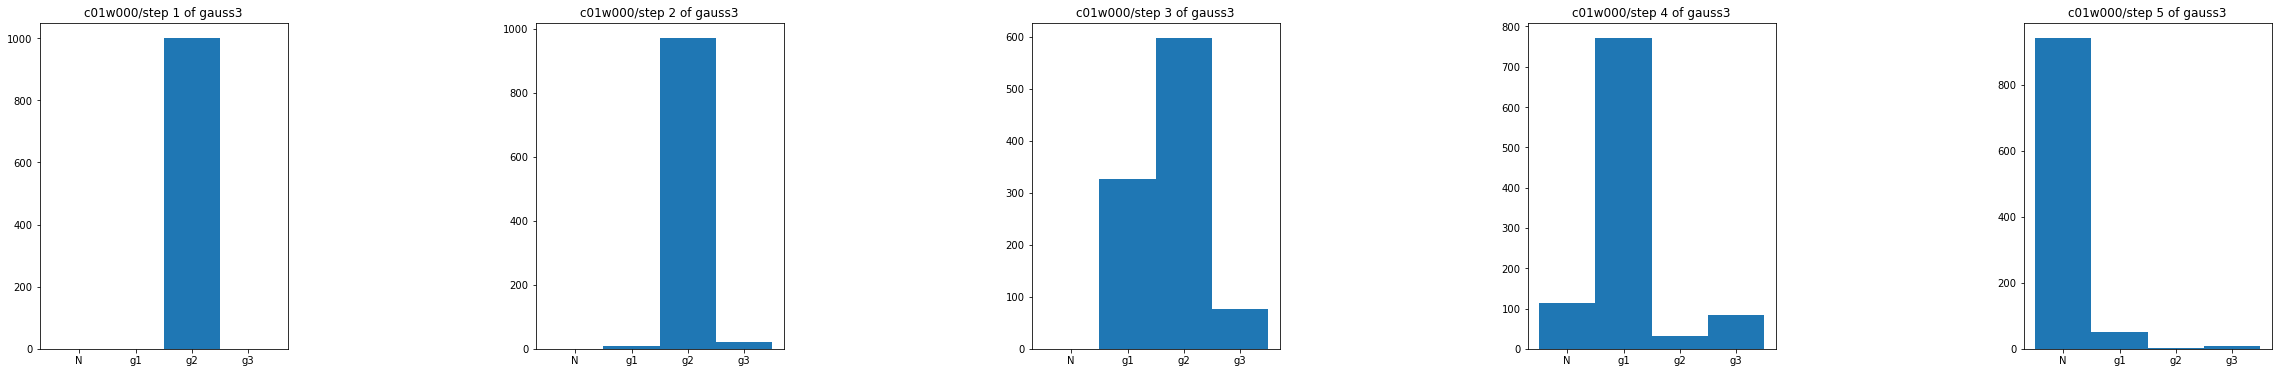

use 4 times gauss3


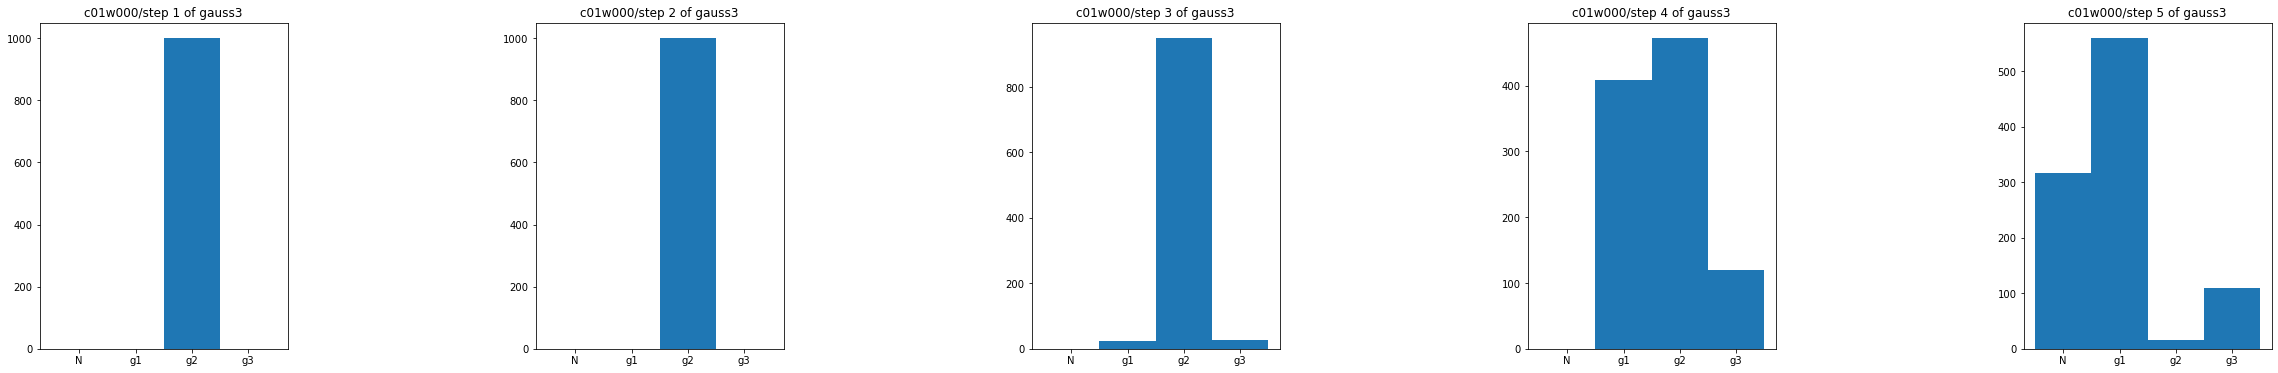

use 5 times gauss3


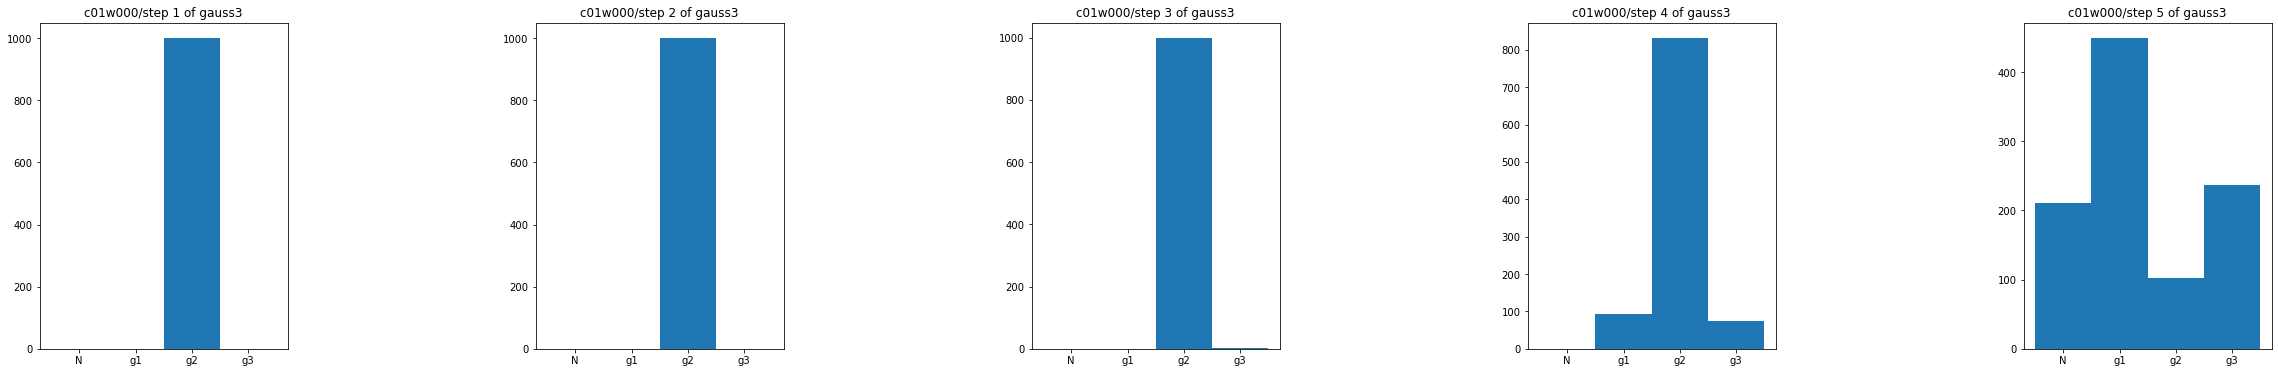

----------



In [26]:
# 選択した行動の分布
view_actions_hist(action_result)

普通にgauss1を適用した時の結果をチェックする

もっといい組み合わせがあるのかを確かめないと

init mse 0.030421083569705264
restore mse 0.004587369098800187
[2, 2, 1, 1, 0]


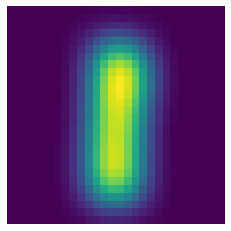

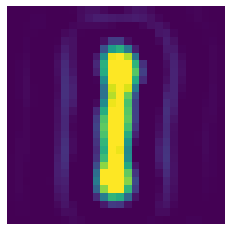

In [64]:
idx = 11
original = test_data[idx]
blurred_img = blur(original, kernel3, c=3)
print('init mse', np.mean((blurred_img-original.numpy())**2))
restore, actions = restore_by_agent(Qnet25, blurred_img)
print('restore mse', torch.mean((restore-original)**2).item())

print(actions)
plt.imshow(blurred_img)
plt.axis('off')
plt.show()

plt.imshow(restore)
plt.axis('off')
plt.show()

init 0.025534274464139833


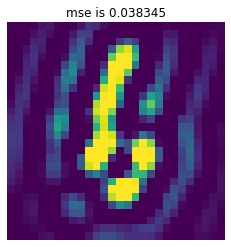

In [270]:
from skimage import restoration
from torch.nn import functional as F
idx = 0
original = test_data[idx]
blurred_img = blur(original, kernel1, c=3)

restore = blurred_img
print('init', F.mse_loss(torch.from_numpy(blurred_img), original).item())
for _ in range(5):
    restore = np.maximum(0, restoration.wiener(restore, kernel1, 1e-2))
restore = torch.from_numpy(restore)
    
plt.title('mse is %lf' % F.mse_loss(original, restore))
plt.axis('off')
plt.imshow(restore)